## Setup
Import modules.

In [2]:
# Line magics.
%reload_ext autoreload
%autoreload 2

# Standard modules.
import numpy as np
rng = np.random.default_rng()

# Custom modules.
from src.format import load_data, load_config, restrict_data, relevant_config, store_results, save_data
from src.training import train
from src.utils import compute_R2

# Plotting modules.
import seaborn as sns
from matplotlib import pyplot as plt

Declare some settings related to decoding (datasets to use, decoders to use, etc.).

In [3]:
# List datasets you wish to run decoders on.
datasets = ['mc_maze'] # to run all datasets write ['mc_maze','mc_rtt','area2_bump']

# List methods you wish to use.
methods = ['kf','wf','ffn','gru']

# Name this run (will determine filename for saved results).
run_name = 'run1'

# Decide what fraction of a dataset's trials should be used for testing.
# The remaining trials will be left for training (a portion of which may
# be used for validation).
test_frac = .2

# Decide whether to use Bayesian optimization to learn hyperparameters (True)
# or whether to use preset hyperparameters from the config file (False).
optimize_flag = False

## Run decoder(s)
Generate results for each dataset, decoder, behavioral variable, etc. according to the settings above and the settings in the relevant config files (the .yaml files in the config directory).

In [ ]:
# Preallocate dictionary for storing results.
Results = {ds: {m: dict() for m in methods} for ds in datasets}

# For each dataset...
for ds in range(len(datasets)):

    # Load and partition dataset.
    Train, Test = load_data(datasets[ds], test_frac)

    # Load config file for this dataset.
    config = load_config(datasets[ds])

    # For each method...
    for m in range(len(methods)):

        # Get list of behavioral variable groups to run separate decoders for.
        var_groups = config[methods[m]]['var_groups']

        # For each behavioral variable group...
        for b in range(len(var_groups)):

            # Restrict data sets to this behavioral variable group.
            Train_b, Test_b = restrict_data(Train, Test, var_groups[b])
            
            # Get settings specific to this method and behavioral variable group.
            model_config = relevant_config(config, methods[m], var_groups[b])

            # Train model.
            model, HyperParams = train(
                Train_b['spikes'], Train_b['behavior'], Train_b['condition'], methods[m], model_config, optimize_flag)

            # Test model.
            Test_b['behavior_estimate'] = model.predict(Test_b['spikes'])

            # Evaluate performance, excluding the first tau samples for
            # which sufficient spiking history did not exist for all methods.
            tau = HyperParams['Delta']*(HyperParams['tau_prime']+1)-1
            R2 = compute_R2(Test_b['behavior'], Test_b['behavior_estimate'], skip_samples=tau, eval_bin_size=5)
            print('{} R2: {} for {}, {}'.format(var_groups[b],R2,datasets[ds],methods[m]))

            # Store performance in 'Results' dictionary.
            store_results(R2, Test_b['behavior'], Test_b['behavior_estimate'],
                HyperParams, Results[datasets[ds]][methods[m]], var_groups[b], Train)

# Save results.
save_data(Results, run_name)

## Plot results
Pick a dataset and behavioral variable group to visualize the results for. Define some labels for plotting as well.

In [5]:
# Make plotting selections.
dataset = 'mc_maze'
var_group = 'vel'

# Create a plotting label to go along with var_group and
# name the components that comprise that var_group.
var_group_label = 'Velocity'
var_group_components = ['x-velocity','y-velocity']

# Create a dictionary that assigns nicely
# formatted labels to each decoding method.
method_labels = {
    'kf': 'Kalman Filter',
    'wf': 'Wiener Filter',
    'ffn': 'Feedforward\nNetwork',
    'gru': 'GRU'
}

Compare aggregate performance across methods by plotting behavior prediction R<sup>2</sup> values on the test sets.

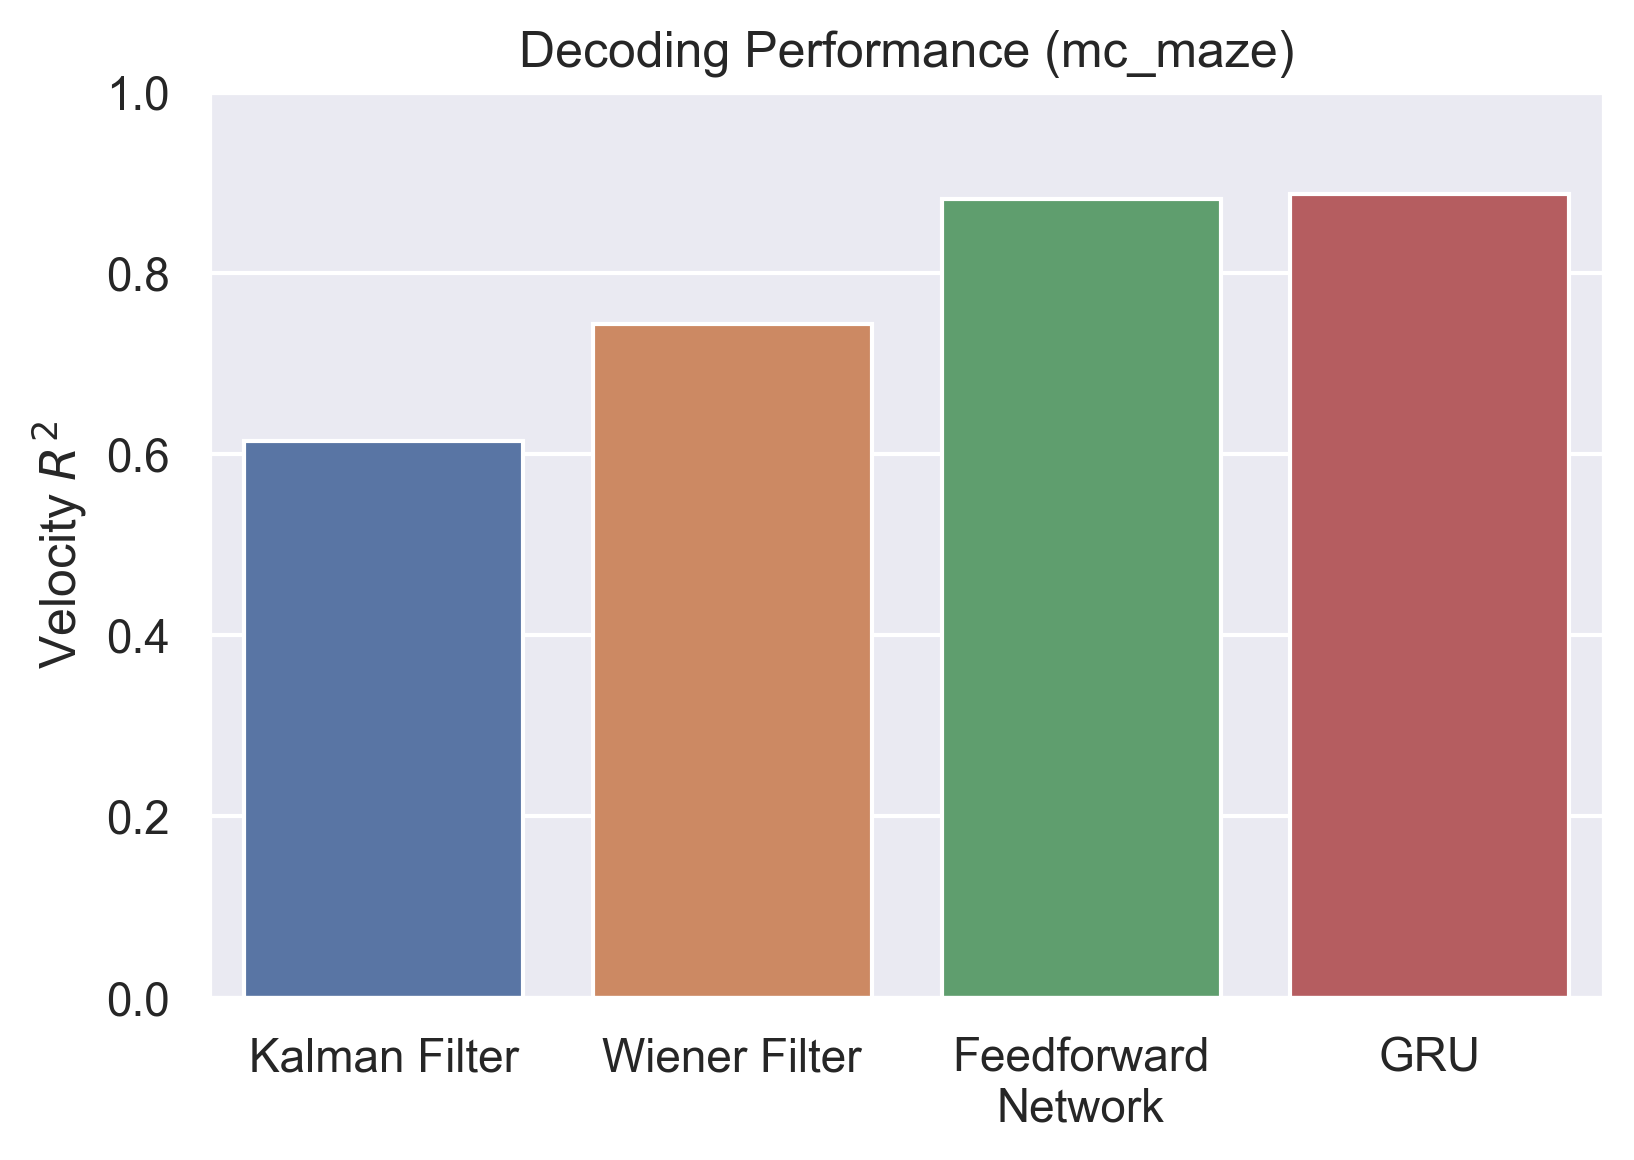

In [7]:
# Aggregate R2 values across methods.
R2 = []
for m in range(len(methods)):
    R2.append(np.mean(Results[dataset][methods[m]][var_group]['R2']))

# Plot these R2 values as a bar plot.
sns.set(rc={"figure.dpi":300}) # increase plotting quality with larger DPI
ax = sns.barplot(x=np.arange(len(R2)), y=R2)
ax.set_xticklabels([method_labels[m] for m in methods])
ax.set_ylim((0,1))
ax.set_ylabel(var_group_label + ' $R^2$')
ax.set_title('Decoding Performance (' + dataset + ')')
plt.show()

Visualize performance by plotting decoded variables for a randomly selected trial. Note that the decoders only generate a new estimate once per time bin, yet a decode must be rendered every millisecond. Thus, in between bins the most recently decoded values are held, hence the 'staircase' appearance in the plots below.

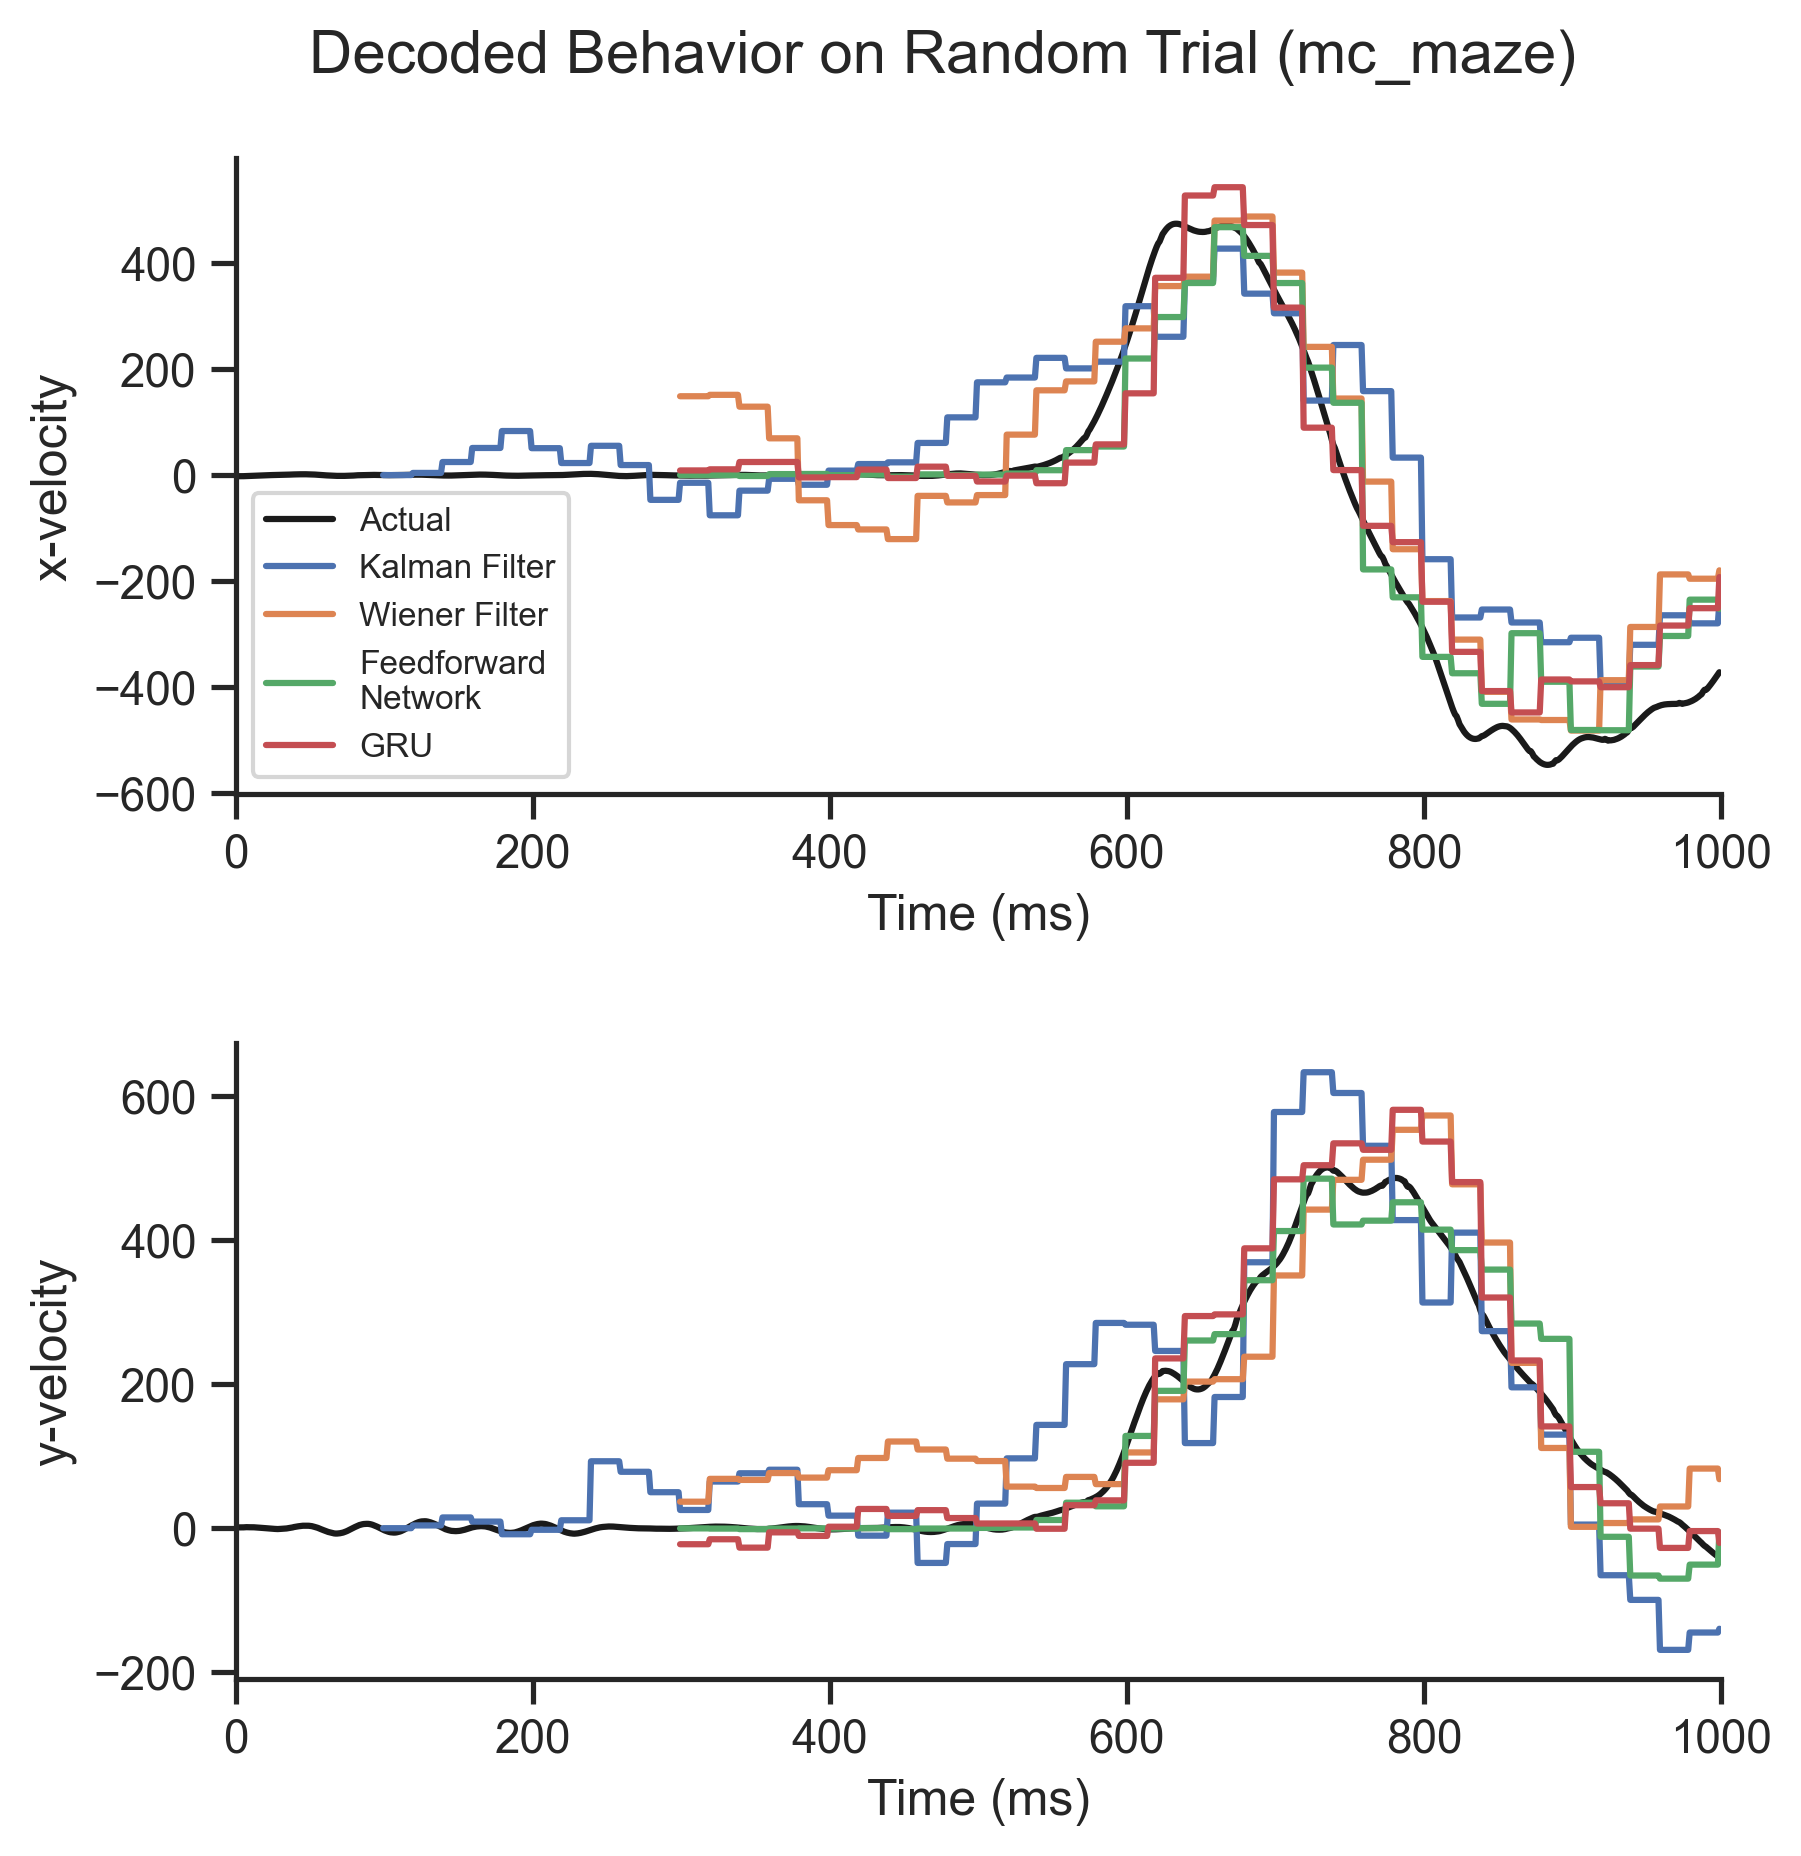

In [8]:
# Get ground truth behaviors for this data set and behavioral variable group.
Z = Results[dataset][methods[0]][var_group]['behavior']

# Determine how many behavioral variables comprise the behavioral variable group.
n_vars = Z[0].shape[0]

# Select a trial at random.
n_trials = len(Z)
tr = rng.integers(low=0, high=n_trials)

# Create axes.
with sns.axes_style('ticks'):

    # Initialize figure.
    fig, axs = plt.subplots(n_vars,1,figsize=(6.4, 3.2*n_vars))
    fig.tight_layout(pad=3.0)

    # Create a subplot for each behavioral variable.
    for i in range(n_vars):

        # Plot ground truth behavior.
        n_times = Z[tr].shape[1]
        ax = sns.lineplot(x=np.arange(n_times), y=Z[tr][i,:], color='k', ax=axs[i])

        # Plot decoded behavior for each method.
        for m in range(len(methods)):
            Z_hat = Results[dataset][methods[m]][var_group]['behavior_estimate']
            sns.lineplot(x=np.arange(Z_hat[tr].shape[1]), y=Z_hat[tr][i,:], ax=axs[i])
        
        # Format the axes.
        ax.set_xlim((0,n_times))
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel(var_group_components[i])
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)

        # Create a legend for the first subplot only.
        if i == 0:
            leg = [method_labels[m] for m in methods]
            leg.insert(0,'Actual')
            ax.legend(leg, prop={'size': 8})

    # Add a title.
    plt.suptitle('Decoded Behavior on Random Trial (' + dataset + ')')
    plt.show()